In [1]:
import sys
from pathlib import Path

main_path = Path().absolute().parent
sys.path.append(str(main_path))

import shap
import numpy as np
import pandas as pd
from IPython.display import display

from fge.tree_builder import TreeBuilder
from fge.modeler import ModelBuilder

shap.initjs()

# Adult Dataset

In [2]:
model_builder = ModelBuilder(
    dataset_name='adult', 
    data_folder='../data', 
    eta=0.3, 
    max_depth=8, 
    subsample=1.0, 
    seed=8
)
results = model_builder.train(num_rounds=200)

performance = results['score']
model = results['model']
dataset = results['dataset']
X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
print(f'test performance is {performance:.4f}')
feature_names = X_train.columns

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

[0]	test-logloss:0.53761
[40]	test-logloss:0.27630
[80]	test-logloss:0.28102
[120]	test-logloss:0.28647
[160]	test-logloss:0.29231
[199]	test-logloss:0.29741
test performance is 0.8674


In [3]:
tree_builder = TreeBuilder(
    task_type=model_builder.task_type, 
    original_score=performance, 
    dataset=dataset
)
trees = tree_builder.build(
    score_method='ratio', 
    shap_interactions=shap_interaction_values, 
    n_select=1,
    max_iter=None
)

Building Tree: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


(7, (3, ((1, (5, 10)), (8, (2, (9, (11, (0, (4, 6)))))))))


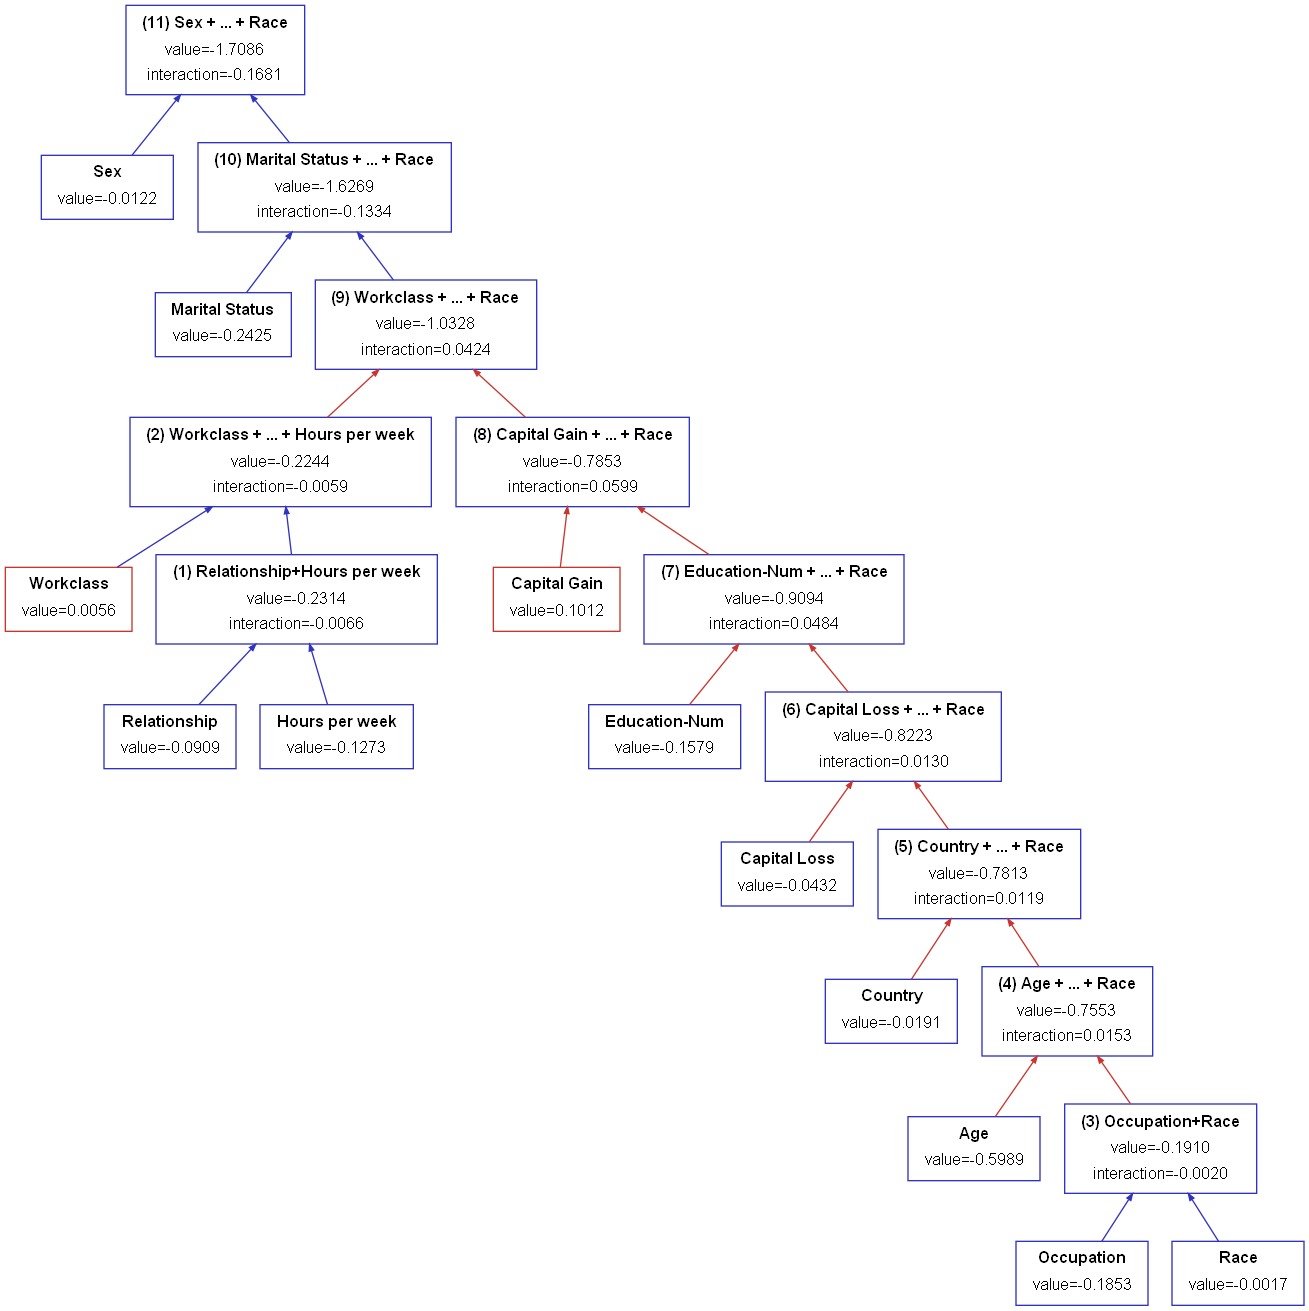

In [4]:
for key, tree in trees:
    print(key)
    display(tree.show_tree(feature_names=feature_names))

In [7]:
[tree_builder.infos[i]['performance'] for i in range(len(tree_builder.infos))]

[0.8673626036229659,
 [0.02364138778016578],
 [0.022720294749769665],
 [0.022720294749769665],
 [0.022720294749769665],
 [0.022720294749769665],
 [0.022720294749769665],
 [0.022720294749769665],
 [0.022720294749769665],
 [0.022720294749769665],
 [0.022720294749769665],
 [0.022720294749769665]]

# Boston

In [5]:
model_builder = ModelBuilder(
    dataset_name='boston', 
    data_folder='../data', 
    eta=0.3, 
    max_depth=8, 
    subsample=1.0, 
    seed=8
)
results = model_builder.train(num_rounds=200)

performance = results['score']
model = results['model']
dataset = results['dataset']
X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
print(f'performance is {performance:.4f}')
feature_names = X_train.columns

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

[0]	test-rmse:17.58955
[40]	test-rmse:4.72624
[80]	test-rmse:4.72890
[120]	test-rmse:4.72856
[160]	test-rmse:4.72856
[199]	test-rmse:4.72856


Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datase

performance is 0.7561


In [6]:
tree_builder = TreeBuilder(
    task_type=model_builder.task_type, 
    original_score=performance, 
    dataset=dataset
)
trees = tree_builder.build(
    score_method='ratio', 
    shap_interactions=shap_interaction_values, 
    n_select=1,
    max_iter=None
)

Building Tree: 100%|██████████| 13/13 [00:00<00:00, 14.43it/s]


(12, ((0, 9), (6, (3, (1, ((10, (5, (2, 7))), (4, (8, 11))))))))


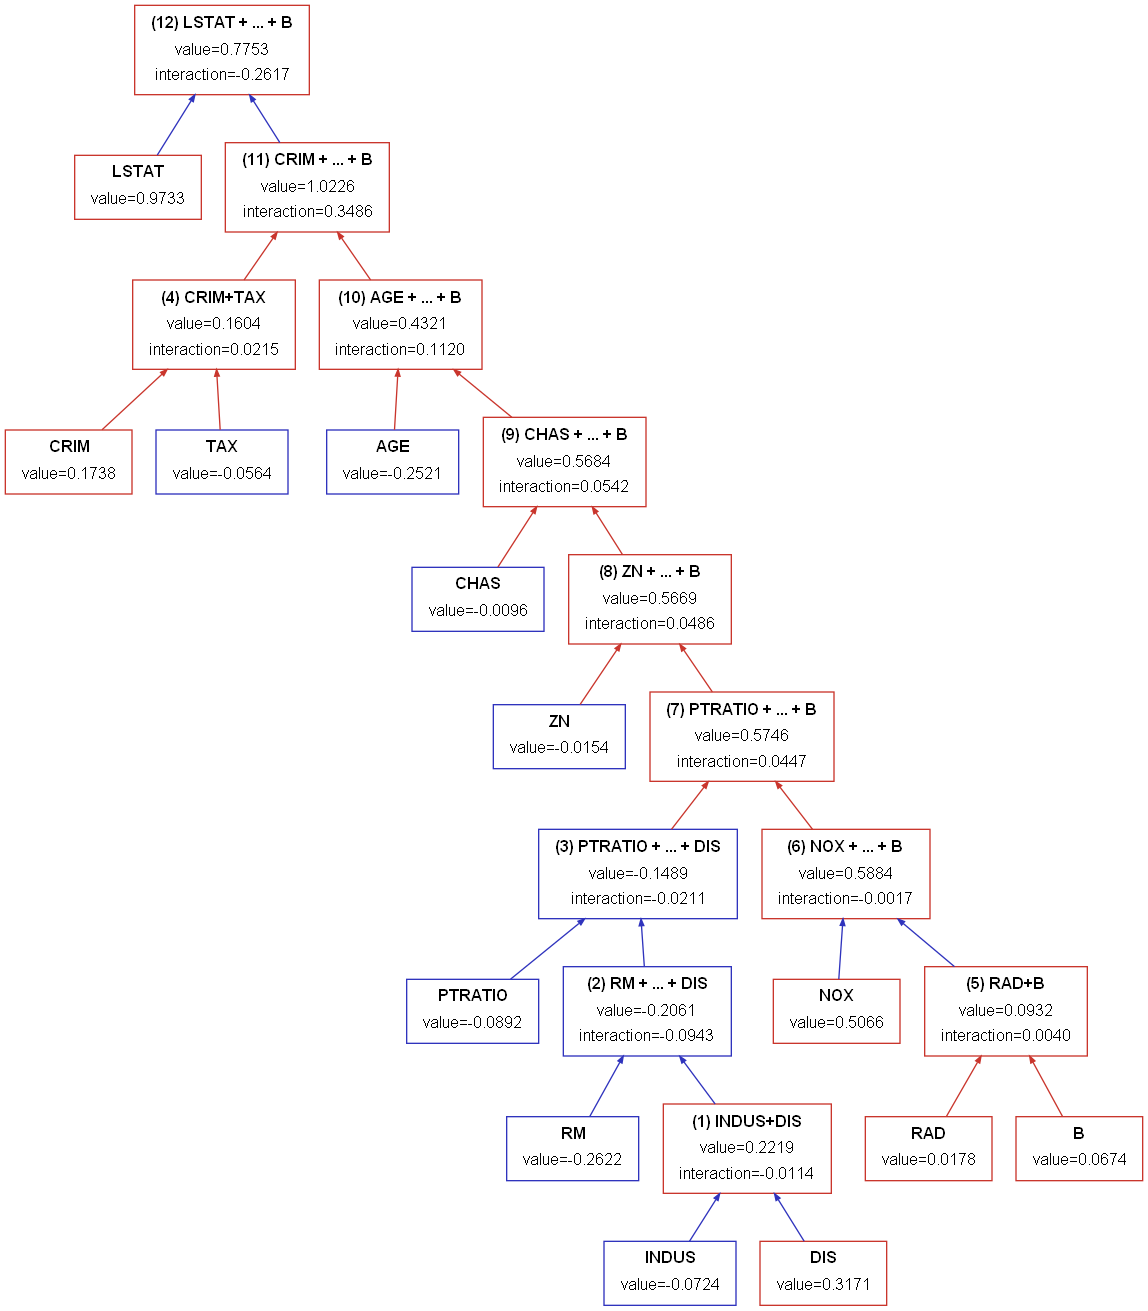

In [7]:
for key, tree in trees:
    print(key)
    display(tree.show_tree(feature_names=feature_names))

In [8]:
[tree_builder.infos[i]['performance'] for i in range(len(tree_builder.infos))]

[0.7560977961396699,
 [0.04152836151536943],
 [0.023878568826826485],
 [0.009595519384247964],
 [-0.0010231250559724625],
 [-0.002749790577345923],
 [-0.00629009366170874],
 [-0.009097754771651978],
 [-0.009124942329911234],
 [-0.009333071236702906],
 [-0.009117713754154155],
 [-0.009112439203457057],
 [-0.007904259496981925]]

# crime

In [19]:
model_builder = ModelBuilder(
    dataset_name='crime', 
    data_folder='../data', 
    eta=0.3, 
    max_depth=8, 
    subsample=1.0, 
    seed=8
)
results = model_builder.train(num_rounds=200)

performance = results['score']
model = results['model']
dataset = results['dataset']
X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
print(f'performance is {performance:.4f}')
feature_names = X_train.columns

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

XGBoostError: [01:11:47] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:138: label must be in [0,1] for logistic regression

In [24]:
model_builder.dataset['y_train']

array([108,   2,  97, ..., 229,  39, 182], dtype=uint8)

In [ ]:
tree_builder = TreeBuilder(
    task_type=model_builder.task_type, 
    original_score=performance, 
    dataset=dataset
)
trees = tree_builder.build(
    score_method='ratio', 
    shap_interactions=shap_interaction_values, 
    n_select=1,
    max_iter=30
)

# nhanesi

In [9]:
model_builder = ModelBuilder(
    dataset_name='nhanesi', 
    data_folder='../data', 
    eta=0.3, 
    max_depth=8, 
    subsample=1.0, 
    seed=8
)
results = model_builder.train(num_rounds=200)

performance = results['score']
model = results['model']
dataset = results['dataset']
X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
print(f'performance is {performance:.4f}')
feature_names = X_train.columns

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

[0]	test-cox-nloglik:6.60687
[40]	test-cox-nloglik:7.00891
[80]	test-cox-nloglik:7.33920
[120]	test-cox-nloglik:7.76343
[160]	test-cox-nloglik:8.15439
[199]	test-cox-nloglik:8.38033
performance is 0.7929


In [10]:
tree_builder = TreeBuilder(
    task_type=model_builder.task_type, 
    original_score=performance, 
    dataset=dataset
)
trees = tree_builder.build(
    score_method='ratio', 
    shap_interactions=shap_interaction_values, 
    n_select=1,
    max_iter=30
)

Building Tree:   0%|          | 0/30 [00:00<?, ?it/s]

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [14]:
new_X_train, new_X_test = tree_builder.polyfitter.get_selected_X(tree_builder.infos[0]['nodes'][0], feature_names=tree_builder.feature_names)

In [18]:
new_X_train.columns[new_X_train.isnull().sum(0) != 0]

Index(['serum_albumin', 'alkaline_phosphatase', 'SGOT', 'BUN', 'calcium',
       'creatinine', 'potassium', 'sodium', 'total_bilirubin', 'serum_protein',
       'red_blood_cells', 'white_blood_cells', 'hemoglobin', 'hematocrit',
       'segmented_neutrophils', 'lymphocytes', 'monocytes', 'eosinophils',
       'basophils', 'band_neutrophils', 'cholesterol', 'urine_pH',
       'sedimentation_rate', 'uric_acid', 'pulse_pressure'],
      dtype='object')

In [ ]:
for key, tree in trees:
    print(key)
    display(tree.show_tree(feature_names=feature_names))